<a href="https://colab.research.google.com/github/hila-chefer/TargetCLIP/blob/main/TargetCLIP_CLIP_guided_image_essence_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
!git clone https://github.com/hila-chefer/TargetCLIP
os.chdir(f'./TargetCLIP')

Cloning into 'TargetCLIP'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 270 (delta 111), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (270/270), 24.39 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=e19c3514aa15ebc3d77222268b7ae8ce77e55f868d1dff6c8f2e55358cb8f925
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8bhf5g7j
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-8bhf5g7j
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369090 sha256=c1ea7214364b9bf863dea5ec61bca041990b85306e79129603f23d8a24454c91
  Stored in directory: /tmp/pip-ephem-wheel-cache-lm53233s/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [3]:
import argparse
import os

import numpy as np
import torch
import torchvision
from torch import optim
from tqdm import tqdm
import clip
from criteria.clip_loss import CLIPLoss
from models.stylegan2.model import Generator
import math
import copy

In [4]:
#@title Aux functions
def get_latent(args, g_ema):
    mean_latent = g_ema.mean_latent(4096)
    latent_code_init_not_trunc = torch.randn(1, 512).cuda()
    with torch.no_grad():
        # _, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
        #                             truncation=args.truncation, truncation_latent=mean_latent)
        _, latent_code_init,_ = g_ema([latent_code_init_not_trunc], return_latents=True,
                                    truncation=args.truncation, truncation_latent=mean_latent)

    direction = latent_code_init.detach().clone()
    direction.requires_grad = True
    return direction


def load_model(args):
    g_ema = Generator(args.stylegan_size, 512, 8)
    g_ema.load_state_dict(torch.load(args.ckpt)["g_ema"], strict=False)
    g_ema.eval()
    g_ema = g_ema.cuda()
    return g_ema


def get_lr(t, initial_lr, rampdown=0.75, rampup=0.005):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

args = {
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr": 0.1,
    "truncation": 0.7,
    "save_intermediate_image_every": 1,
    "results_dir": "results",
    "dir_name": "results",
    "num_batches": 1,
    "real_images": True,
    "data_path": "train_faces.pt",
}

from argparse import Namespace
a=Namespace(**args)

g_ema = load_model(a)


##**Option 1**: a celebrity source 

In [27]:
dirs = {
  'Elsa': 'dirs/elsa.npy',
  'Pocahontas': 'dirs/pocahontas.npy',
  'Keanu Reeves': 'dirs/keanu.npy',
  'Trump': 'dirs/trump.npy',
  'Joker': 'dirs/joker.npy',
  'Ariel': 'dirs/ariel.npy',
  'Doc Brown': 'dirs/doc.npy',
  'Beyonce': 'dirs/beyonce.npy',
  'Morgan Freeman': 'dirs/morgan.npy',
  'Avatar': 'dirs/avatar.npy',
  'Wolverine': 'dirs/wolverine.npy',
  'Gargamel': 'dirs/gargamel.npy',
}

targets = {
  'Elsa': 'dirs/targets/elsa.jpg',   
  'Pocahontas': 'dirs/targets/pocahontas.jpg',
  'Keanu Reeves': 'dirs/targets/keanu.jpg',
  'Trump': 'dirs/targets/trump.jpg',
  'Joker': 'dirs/targets/joker.jpg',
  'Ariel': 'dirs/targets/ariel.jpeg',
  'Doc Brown': 'dirs/targets/doc_brown.jpg',
  'Beyonce': 'dirs/targets/beyonce.jpg',
  'Morgan Freeman': 'dirs/targets/morgan_freeman.jpg',
  'Avatar': 'dirs/targets/avatar.jpg',
  'Wolverine': 'dirs/targets/wolverine.jpg',
  'Gargamel': 'dirs/targets/Gargamel.png',
}

sources_ids = {
  'Taylor Swift': 67,   
  'Elon Musk': 4,
  'Hillary Clinton': 9,
  'Alfie Allen': 34,
  'Obama': 61
}

target = 'Joker' #@param ['Trump','Keanu Reeves', 'Elsa', 'Pocahontas', 'Joker', 'Ariel', 'Doc Brown', 'Beyonce', 'Morgan Freeman', 'Avatar', 'Wolverine', 'Gargamel']
source_name = 'Hillary Clinton' #@param ['Taylor Swift', 'Elon Musk', 'Hillary Clinton', 'Alfie Allen', 'Obama']

sources = torch.from_numpy(np.load('dirs/w_plus.npy'))
source = sources[sources_ids[source_name]].unsqueeze(0)
dir = torch.from_numpy(np.load(dirs[target]))
target_path = targets[target]

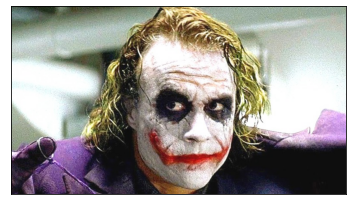

In [28]:
#@title Show target image
assert(target_path is not None)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(target_path)
imgplot = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


(-0.5, 1023.5, 1023.5, -0.5)

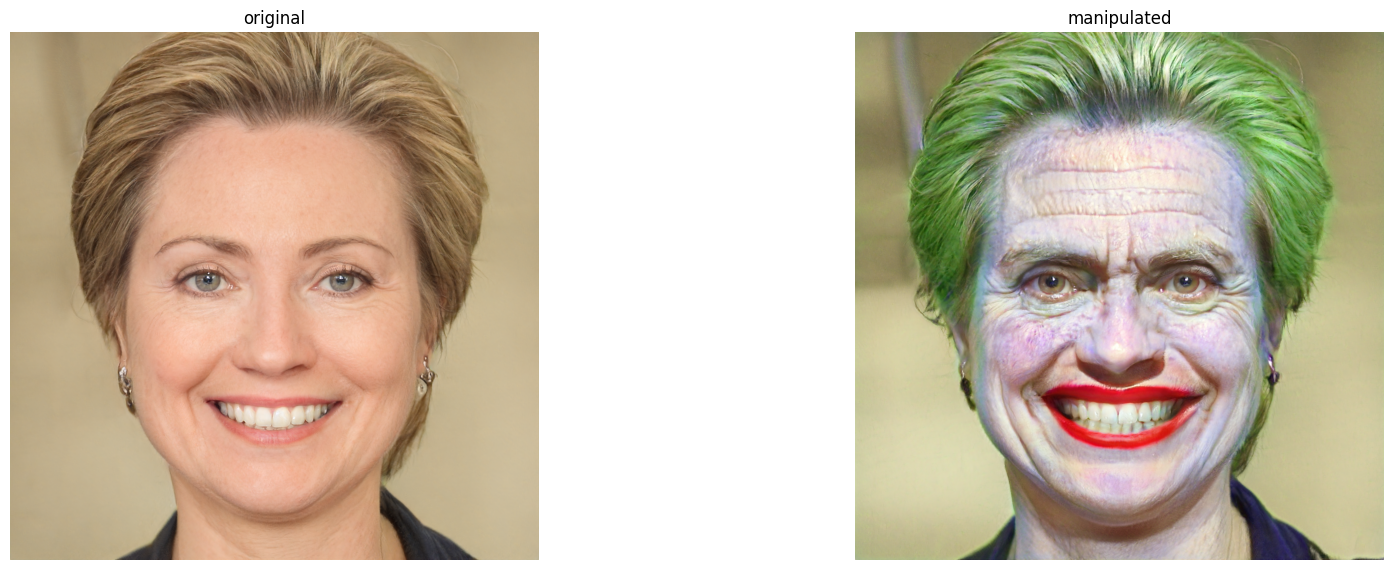

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#alpha=1
alpha = 1.1 #@param {type:"slider", min:0, max:2, step:0.1}
dir = dir.cuda()
source = source.cuda()
source_img, _ = g_ema([source], input_is_latent=True, randomize_noise=False)
source_amp, _ = g_ema([source + dir * alpha], input_is_latent=True,
                        randomize_noise=False)

torchvision.utils.save_image(source_img, f"results_orig.png", normalize=True, range=(-1, 1))
torchvision.utils.save_image(source_amp, f"results_manipulated.png", normalize=True, range=(-1, 1))
plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(mpimg.imread('results_orig.png'))
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mpimg.imread('results_manipulated.png'))
plt.title('manipulated')
plt.axis('off')

##**Option 2**: your own inverted source

In [30]:
dirs = {
  'Elsa': 'dirs/elsa.npy',
  'Pocahontas': 'dirs/pocahontas.npy',
  'Keanu Reeves': 'dirs/keanu.npy',
  'Trump': 'dirs/trump.npy',
  'Joker': 'dirs/joker.npy',
  'Ariel': 'dirs/ariel.npy',
  'Doc Brown': 'dirs/doc.npy',
  'Beyonce': 'dirs/beyonce.npy',
  'Morgan Freeman': 'dirs/morgan.npy',
  'Avatar': 'dirs/avatar.npy',
  'Wolverine': 'dirs/wolverine.npy',
  'Gargamel': 'dirs/gargamel.npy',
}

targets = {
  'Elsa': 'dirs/targets/elsa.jpg',   
  'Pocahontas': 'dirs/targets/pocahontas.jpg',
  'Keanu Reeves': 'dirs/targets/keanu.jpg',
  'Trump': 'dirs/targets/trump.jpg',
  'Joker': 'dirs/targets/joker.jpg',
  'Ariel': 'dirs/targets/ariel.jpeg',
  'Doc Brown': 'dirs/targets/doc_brown.jpg',
  'Beyonce': 'dirs/targets/beyonce.jpg',
  'Morgan Freeman': 'dirs/targets/morgan_freeman.jpg',
  'Avatar': 'dirs/targets/avatar.jpg',
  'Wolverine': 'dirs/targets/wolverine.jpg',
  'Gargamel': 'dirs/targets/Gargamel.png',
}

sources_ids = {
  'Taylor Swift': 67,   
  'Elon Musk': 4,
  'Hillary Clinton': 9,
  'Alfie Allen': 34,
  'Obama': 61
}

target = 'Elsa' #@param ['Trump','Keanu Reeves', 'Elsa', 'Pocahontas', 'Joker', 'Ariel', 'Doc Brown', 'Beyonce', 'Morgan Freeman', 'Avatar', 'Wolverine', 'Gargamel']
latent_path = "dirs/me.pt" #@param {type:"string"}
source = torch.load(latent_path).unsqueeze(0)
dir = torch.from_numpy(np.load(dirs[target]))
target_path = targets[target]

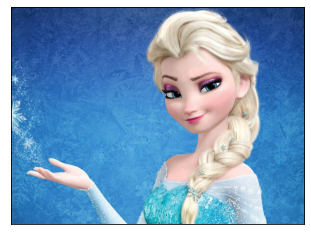

In [31]:
#@title Show target image
assert(target_path is not None)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(target_path)
imgplot = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


(-0.5, 1023.5, 1023.5, -0.5)

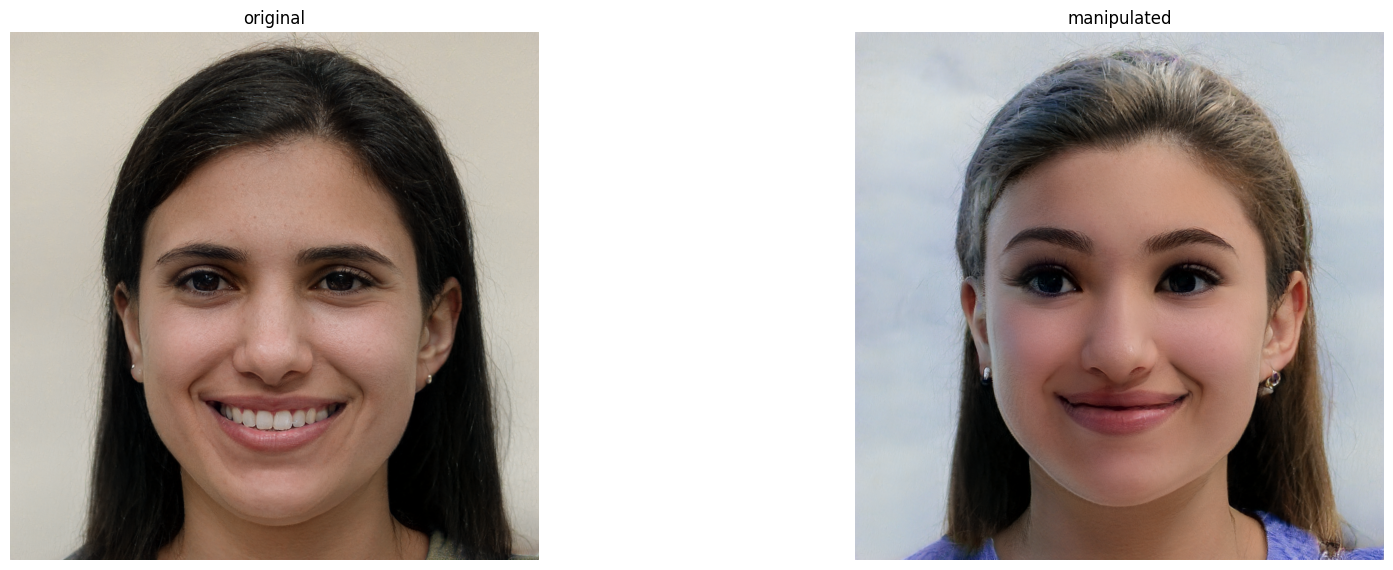

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#alpha=1
alpha = 0.8 #@param {type:"slider", min:0, max:2, step:0.1}
dir = dir.cuda()
source = source.cuda()
source_img, _ = g_ema([source], input_is_latent=True, randomize_noise=False)
source_amp, _ = g_ema([source + dir * alpha], input_is_latent=True,
                        randomize_noise=False)

torchvision.utils.save_image(source_img, f"results_orig.png", normalize=True, range=(-1, 1))
torchvision.utils.save_image(source_amp, f"results_manipulated.png", normalize=True, range=(-1, 1))
plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(mpimg.imread('results_orig.png'))
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mpimg.imread('results_manipulated.png'))
plt.title('manipulated')
plt.axis('off')